In [57]:
import pandas as pd
# Load the dataset
df = pd.read_csv('card_stats_royalapi (2).csv')

# Check dataset shape and missing values
print("Shape:", df.shape)
print("Missing values per column:\n", df.isnull().sum())



Shape: (647, 5)
Missing values per column:
 CardName    0
Bracket     0
UsagePct    0
WinPct      0
Rating      0
dtype: int64


In [58]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Features and target for regression
X = df[['UsagePct', 'Rating', 'Bracket']]
y = df['WinPct']

# 80/20 train test split for regression
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=10
)

# Preprocessing: one hot encode the Bracket feature
preprocessor = ColumnTransformer(
    transformers=[('bracket_ohe', OneHotEncoder(drop='first'), ['Bracket'])],
    remainder='passthrough'
)


In [59]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.metrics import mean_squared_error



# Pipeline: Preprocessing and Linear Regression
pipe_lin = Pipeline([
    ('preprocess', preprocessor),
    ('linreg', LinearRegression())
])
pipe_lin.fit(X_train, y_train)

# Predict on test set and evaluate
y_pred_lin = pipe_lin.predict(X_test)
mse_lin = mean_squared_error(y_test, y_pred_lin)
rmse_lin = np.sqrt(mse_lin)
r2_lin = r2_score(y_test, y_pred_lin)

print(f"Linear Regression: RMSE = {rmse_lin:.3f}, R^2 = {r2_lin:.3f}")


Linear Regression: RMSE = 4.361, R^2 = 0.488


In [60]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.metrics import mean_squared_error
# Pipeline: Preprocessing and Gradient Boosting Regressor
pipe_gb = Pipeline([
    ('preprocess', preprocessor),
    ('gbreg', GradientBoostingRegressor(random_state=42))
])
pipe_gb.fit(X_train, y_train)

# Predict on test set and evaluate
y_pred_gb = pipe_gb.predict(X_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mse_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print(f"Gradient Boosting Regressor: RMSE = {rmse_gb:.3f}, R^2 = {r2_gb:.3f}")


Gradient Boosting Regressor: RMSE = 1.891, R^2 = 0.904


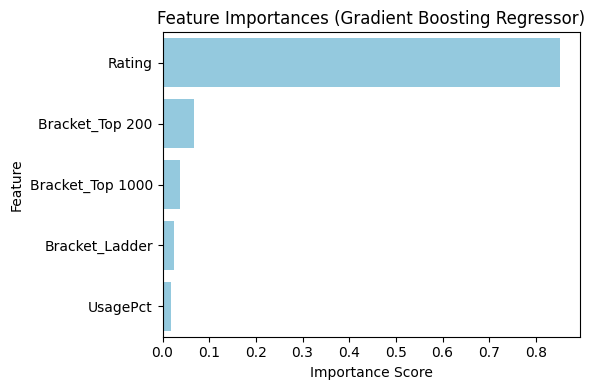

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature names after one hot encoding
ohe = pipe_gb.named_steps['preprocess'].named_transformers_['bracket_ohe']
dummy_features = list(ohe.get_feature_names_out(['Bracket']))
numeric_features = ['UsagePct', 'Rating']
features = dummy_features + numeric_features

# Get importance scores and sort them in descending order
importances = pipe_gb.named_steps['gbreg'].feature_importances_
sorted_idx = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_idx]
sorted_features = [features[i] for i in sorted_idx]

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=sorted_importances, y=sorted_features, color='skyblue')
plt.title('Feature Importances (Gradient Boosting Regressor)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


In [62]:
# Create popularity category based on UsagePct quantiles
df['Popularity'] = pd.qcut(df['UsagePct'], q=3, labels=['Low', 'Medium', 'High'])

# Check the distribution of the new Popularity classes
print(df['Popularity'].value_counts())


Popularity
Low       252
Medium    211
High      184
Name: count, dtype: int64


In [63]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Features  and target for classification
X = df[['UsagePct', 'WinPct', 'Rating', 'Bracket']]
y = df['Popularity']

# Stratified train test split for classification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Preprocessing: one hot encode Bracket
preprocessor_clf = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['UsagePct', 'WinPct', 'Rating']),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ['Bracket']),
    ]
)

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

# Pipeline: Preprocessing and Multinomial Logistic Regression
pipe_log = Pipeline([
    ('preprocess', preprocessor_clf),
    ('logreg', LogisticRegression(
    solver='lbfgs',
    max_iter=5000,
    random_state=42
))
])
pipe_log.fit(X_train, y_train)

# Predict on test set
y_pred_log = pipe_log.predict(X_test)
acc_log = accuracy_score(y_test, y_pred_log)
f1_log  = f1_score(y_test, y_pred_log, average='macro')
print(f"Logistic Regression: Accuracy = {acc_log:.3f}, Macro F1 = {f1_log:.3f}")


Logistic Regression: Accuracy = 0.908, Macro F1 = 0.905


In [65]:
from sklearn.ensemble import RandomForestClassifier

# Pipeline: Preprocessing and Random Forest
pipe_rf = Pipeline([
    ('preprocess', preprocessor_clf),
    ('rf', RandomForestClassifier(random_state=42))
])
pipe_rf.fit(X_train, y_train)

# Predict on test set
y_pred_rf = pipe_rf.predict(X_test)
acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf  = f1_score(y_test, y_pred_rf, average='macro')
print(f"Random Forest: Accuracy = {acc_rf:.3f}, Macro F1 = {f1_rf:.3f}")


Random Forest: Accuracy = 1.000, Macro F1 = 1.000


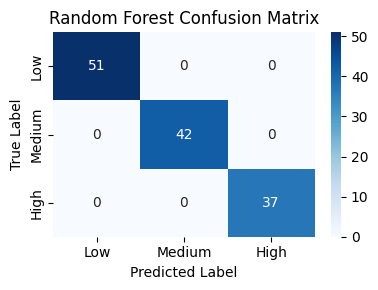

In [66]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion matrix for Random Forest on test data
labels = ['Low', 'Medium', 'High']
cm = confusion_matrix(y_test, y_pred_rf, labels=labels)
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Random Forest Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


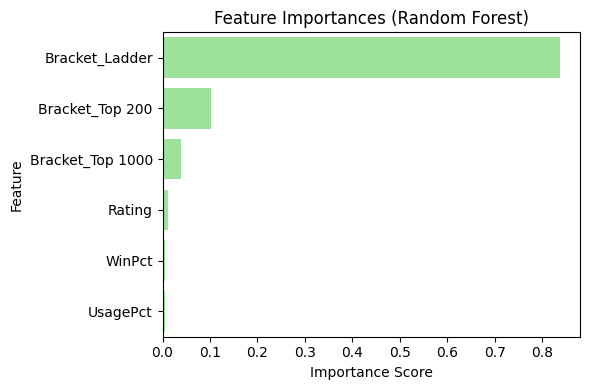

In [67]:
# Feature importance from Random Forest
ohe = pipe_rf.named_steps['preprocess'].named_transformers_['cat']
feature_names = list(ohe.get_feature_names_out(['Bracket'])) + ['UsagePct', 'WinPct', 'Rating']
importances = pipe_rf.named_steps['rf'].feature_importances_

# Sort
indices = np.argsort(importances)[::-1]
sorted_importances = importances[indices]
sorted_features = [feature_names[i] for i in indices]

# Plot
plt.figure(figsize=(6,4))
sns.barplot(x=sorted_importances, y=sorted_features, color='lightgreen')
plt.title('Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
